In [1]:
import scipy.ndimage as sim
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
def count_distance_to_centre(region, centre_of_lumen, dists, only_angle = True):
    
    if only_angle == False:

        for n in range(region.shape[0]):
                dists[n, 0] = np.sqrt((region[n, 0]-centre_of_lumen[0])**2+(region[n, 1]-centre_of_lumen[1])**2)
                dists[n, 1] = np.degrees(np.arctan2((region[n, 0]-centre_of_lumen[0]), (region[n, 1]-centre_of_lumen[1])))

    else:
        for n in range(region.shape[0]):
                dists[n, 0] = np.degrees(np.arctan2((region[n, 0]-centre_of_lumen[0]), (region[n, 1]-centre_of_lumen[1])))

    return dists
    

In [3]:
def create_annotations(image_seg, im_insize = 704, bin_size = 2):    

    image = sitk.GetArrayFromImage(image_seg)[0]

    # Define segmentations
    vessel_center = image == 1
    vessel_guide = image == 2
    vessel_lipid = image == 4
    vessel_wall = image == 3
    vessel_calcium = image == 5
    
    # Pixel IDs segmentations
    wall_pixels = np.argwhere(vessel_wall)
    lipid_pixels = np.argwhere(vessel_lipid)
    guide_pixels = np.argwhere(vessel_guide)
    calcium_pixels = np.argwhere(vessel_calcium)

    n_bins = 360 // bin_size

    if lipid_pixels.size==0 and calcium_pixels.size==0:

        vessel_com = sim.center_of_mass(vessel_center)

        dist_guide = np.zeros((guide_pixels.shape[0], 1))

        for n in range(guide_pixels.shape[0]):
            dist_guide[n, 0] = np.degrees(
                np.arctan2((guide_pixels[n, 0] - vessel_com[0]), (guide_pixels[n, 1] - vessel_com[1])))
        hist_count_tube, bins_tube = np.histogram(dist_guide[:, 0], n_bins, (-180, 180))

        # thickness per lipid/calcium bin
        thickness_bin = np.zeros(bins_tube.shape[0] - 1)
        for n in range(thickness_bin.shape[0] - 1):
            if hist_count_tube[n] > 0:
                thickness_bin[n] = -1

        return np.zeros((im_insize, im_insize), np.uint8), thickness_bin, 0, 0

    else:
    
        # Center of mass of vessel center
        vessel_com = sim.center_of_mass(vessel_center)

        # Determine distance and angle of pixels relative to COM
        dist_wall = np.zeros((wall_pixels.shape[0], 2))
        dist_lipid = np.zeros((lipid_pixels.shape[0], 1))
        dist_guide = np.zeros((guide_pixels.shape[0], 1))
        dist_calcium = np.zeros((calcium_pixels.shape[0], 2))


        dist_wall = count_distance_to_centre(wall_pixels, vessel_com, dist_wall, only_angle=False)
        dist_lipid = count_distance_to_centre(lipid_pixels, vessel_com, dist_lipid)
        dist_guide = count_distance_to_centre(guide_pixels, vessel_com, dist_guide)
        dist_calcium = count_distance_to_centre(calcium_pixels, vessel_com, dist_calcium, only_angle=False)

            
        # Bin pixels in 360 degree bins
        hist_count_lipid, bins = np.histogram(dist_lipid[:, 0], n_bins, (-180, 180))
        hist_count_guide, _ = np.histogram(dist_guide[:, 0], n_bins, (-180, 180))

        lipid_ids = np.where(hist_count_lipid > 20)[0]

        if lipid_ids.size == 0:
 
            thickness_bin = np.zeros(n_bins)

            for n in range(thickness_bin.shape[0] - 1):
                    if hist_count_tube[n] > 0:
                        thickness_bin[n] = -1
                        
            return np.zeros((im_insize, im_insize), np.uint8), thickness_bin, 0, 0

        # Merge labels and generate new image (new labels: lipid + wall, calcium, catheter, rest)
        new_image = np.copy(image).astype('int16')
        new_image[new_image == 2] = 10
        new_image[new_image == 4] = 0
        new_image[new_image == 5] = 3
        new_image[new_image == 6] = 0
        new_image[new_image == 7] = 1
        new_image[new_image == 8] = 10
        new_image[new_image == 9] = 10
        new_image[new_image == 10] = 10
        new_image[new_image == 11] = 10
        new_image[new_image == 12] = 10

        edges1 = np.abs(np.diff(new_image, axis=0))
        edges2 = np.abs(np.diff(new_image, axis=1))

        #Getting wall contours
        contours = np.zeros((image.shape))
        contours2 = np.zeros((image.shape))
        contours[:image.shape[0]-1, :image.shape[0]] = edges1 == 3
        contours2[:image.shape[0], :image.shape[0]-1] = edges2 == 3
        contours[contours == 0] = contours2[contours == 0]

        #Getting lumen contours
        contours3 = np.zeros((image.shape))
        contours4 = np.zeros((image.shape))
        contours3[:image.shape[0]-1, :image.shape[0]] = edges1 == 2
        contours4[:image.shape[0], :image.shape[0]-1] = edges2 == 2
        contours3[contours3 == 0] = contours4[contours3 == 0]

        id1 = np.argwhere(contours == 1)
        id2 = np.argwhere(contours3 == 1)

        #Calculate angle of each pixel in the wall with the horizontal axis
        wcontour_pixels = np.argwhere(contours)
        dist_wcontour = np.zeros((wcontour_pixels.shape[0], 1))

        for n in range(wcontour_pixels.shape[0]):
            dist_wcontour[n, 0] = np.degrees(
                np.arctan2((wcontour_pixels[n, 0] - vessel_com[0]), (wcontour_pixels[n, 1] - vessel_com[1])))
            
        hist_count_wcontour, _ = np.histogram(dist_wcontour[:, 0], n_bins, (-180, 180))
        wall_nids = np.where(hist_count_wcontour == 0)[0]

        splits = np.flatnonzero(np.diff(wall_nids) != 1)
        sub_arrs = np.split(wall_nids, splits + 1)

        if np.isin(0,wall_nids) and np.isin(n_bins-1, wall_nids):
            sub_arrs[0] = np.concatenate((sub_arrs[0],sub_arrs[-1]))
            del sub_arrs[-1]

        for n in range(len(sub_arrs)):

            # Add tube ids if lipid overlaps tube at both sides
            overlap_lipid_guide = np.isin(lipid_ids, np.concatenate((wall_nids-3,wall_nids+3)))

            if np.sum(overlap_lipid_guide) > 1:

                overlap_lipid_ids = lipid_ids[overlap_lipid_guide]
                overlap_lipid_guide_diff = np.diff(overlap_lipid_ids)
                max_diff_id = np.argmax(overlap_lipid_guide_diff)

                if overlap_lipid_guide_diff[max_diff_id] > 1:

                    added_ids = np.unique(np.concatenate((wall_nids-3,wall_nids,wall_nids+3)))
                    # Only add IDs that fall within 0 - 179 range
                    added_ids = added_ids[(added_ids>-1) & (added_ids<180)]
                    lipid_ids = np.unique(np.concatenate((lipid_ids,added_ids)))
                
        lipid_angle_deg = len(lipid_ids)/(n_bins)*360

        # Detect edges of lipid
        lipid_bool = np.zeros(n_bins)
        lipid_bool[lipid_ids] = 1

        # There is no lipid in the image or the image is all lipid
        if np.sum(lipid_bool < 1)==0 or np.sum(lipid_bool < 1)==lipid_bool.shape[0]:
            lipid_edges = np.array([])

        else:
            # Differences of 0 to 1 or 1 to 0 are edges of the lipid
            lipid_edges = np.where(np.abs(np.diff(lipid_bool)) > 0)[0]

            # Not sure what's going on here
            if np.abs(lipid_bool[0]-lipid_bool[-1])>0:
                lipid_edges = np.concatenate((lipid_edges,np.array([-1])))
                                      
            if lipid_bool[lipid_edges[0]] > 0:
                lipid_edges = np.roll(lipid_edges,1)
                
            lipid_edges = lipid_edges + 1
            
        lipid_edge1 = np.zeros((lipid_edges.size//2,2))
        lipid_edge2 = np.zeros((lipid_edges.size//2,2))
        lipid_angles = np.zeros((lipid_edges.size//2,2))

        # Calculate lipid edge coordinates
        for n in range(lipid_edges.size//2):

            #This is just each coord in lipid_edges, and the angle for each one
            lipid_angle_ids = [lipid_edges[2*n],lipid_edges[2*n+1]]
            lipid_angles[n] = bins[lipid_angle_ids]+bin_size/2

            #Gets coordinate through which each arc is defined
            lipid_edge1[n,0] = vessel_com[1]+(image.shape[0]*0.4*np.cos(np.radians(lipid_angles[n,0])))
            lipid_edge1[n,1] = vessel_com[0]+(image.shape[0]*0.4*np.sin(np.radians(lipid_angles[n,0])))

            lipid_edge2[n,0] = vessel_com[1]+(image.shape[0]*0.4*np.cos(np.radians(lipid_angles[n,1])))
            lipid_edge2[n,1] = vessel_com[0]+(image.shape[0]*0.4*np.sin(np.radians(lipid_angles[n,1])))


        lipid_bins = bins[lipid_ids]

        # Calculate coordinates thinnest point
        angle_edge1 = np.zeros((id1.shape[0], 1))
        angle_edge2 = np.zeros((id2.shape[0], 1))

        for n in range(id1.shape[0]):
            angle_edge1[n, 0] = np.degrees(np.arctan2((id1[n, 0]-vessel_com[0]), (id1[n, 1]-vessel_com[1])))

        for n in range(id2.shape[0]):
            angle_edge2[n, 0] = np.degrees(np.arctan2((id2[n, 0]-vessel_com[0]), (id2[n, 1]-vessel_com[1])))
        

        angle_bin1 = np.digitize(angle_edge1[:, 0], bins)
        angle_bin2 = np.digitize(angle_edge2[:, 0], bins)
        thin_id1 = np.isin(bins[angle_bin1-1],lipid_bins)
        thin_id2 = np.isin(bins[angle_bin2-1],lipid_bins)

        id1_lipid = id1[thin_id1]
        id2_lipid = id2[thin_id2]

        id1_min = np.zeros(id1_lipid.shape[0])
        id1_argmin = np.zeros(id1_lipid.shape[0]).astype('int16')

        if id1_lipid.size==0 or id2_lipid.size==0:
            thickness = np.nan


        for n in range(id1_lipid.shape[0]):
            C = []
            for nn in range(id2_lipid.shape[0]):
                C.append((id1_lipid[n,0]-id2_lipid[nn,0])**2+(id1_lipid[n,1]-id2_lipid[nn,1])**2)

            id1_argmin[n] = np.argmin(C)
            id1_min[n] = C[id1_argmin[n]]
        
        contours3[contours3==0]=contours[contours3==0]

        id1m = np.argmin(id1_min)
        id2m = id1_argmin[id1m]

        #Spacing depends on size of image (checked on DCM metadata)
        if image.shape[0] == 1024:
            conv_fact = 0.68

        else:
            conv_fact = 1
   
        id1_min = np.sqrt(id1_min)*1000/conv_fact
        thickness = id1_min[id1m]/100
        
        thin_x = id1_lipid[id1m,1]
        thin_y = id1_lipid[id1m,0]
        thin_x2 = id2_lipid[id2m,1]
        thin_y2 = id2_lipid[id2m,0]
        
        # thickness per lipid/calcium bin
        thickness_bin = np.zeros(bins.shape[0]-1)                
        for n in range(thickness_bin.shape[0]-1):
            try:
                thickness_bin[n] = np.min(id1_min[angle_bin1[thin_id1]==(n+1)])
            except (ValueError, TypeError):
                if hist_count_guide[n]>0:
                    thickness_bin[n] = -1
                
        # Pil manipulations
        overlay = np.zeros((image.shape[0],image.shape[1]), np.uint8) 
        pil_image = Image.fromarray(overlay)

        contour_image = Image.fromarray(contours.astype('uint8')*16).convert('L')
        pil_image.paste(contour_image)
        
        img1 = ImageDraw.Draw(pil_image)   
        img1.line([(thin_x,thin_y),(thin_x2,thin_y2)], fill = 13, width = 3)
        dotsize=3
        img1.ellipse([(thin_x-dotsize,thin_y-dotsize),(thin_x+dotsize,thin_y+dotsize)], fill = 13, width = 0) 
        img1.ellipse([(thin_x2-dotsize,thin_y2-dotsize),(thin_x2+dotsize,thin_y2+dotsize)], fill = 13, width = 0)
        
        
        for n in range(lipid_edges.shape[0]//2):
            img1.line([(vessel_com[1], vessel_com[0]), (lipid_edge1[n,0], lipid_edge1[n,1])],fill = 14, width = 3)
            img1.line([(vessel_com[1], vessel_com[0]), (lipid_edge2[n,0], lipid_edge2[n,1])],fill = 14, width = 3)

            dotsize=3
            img1.ellipse([(lipid_edge1[n,0]-dotsize,lipid_edge1[n,1]-dotsize),(lipid_edge1[n,0]+dotsize,lipid_edge1[n,1]+dotsize)], fill = 14, width = 0) 
            img1.ellipse([(lipid_edge2[n,0]-dotsize,lipid_edge2[n,1]-dotsize),(lipid_edge2[n,0]+dotsize,lipid_edge2[n,1]+dotsize)], fill = 14, width = 0) 
            img1.arc([(vessel_com[1]-30,vessel_com[0]-30),(vessel_com[1]+30,vessel_com[0]+30)],start = lipid_angles[n,0],end = lipid_angles[n,1], fill = 14, width = 3)
        
        # Resize back to original size before adding text
        pil_image = pil_image.resize((im_insize,im_insize), Image.NEAREST)
        
        img1 = ImageDraw.Draw(pil_image) 
        img1.fontmode = "L"
        fnt = ImageFont.truetype("./arial-unicode-ms.ttf",14)

        cap_thickness = '%.0f' % thickness
        lipid_arc = '%.0f' % np.round(lipid_angle_deg)
        img1.text((536,28),'Wall width: ' + '%.0f' % thickness + 'μm', font = fnt, fill=15)
        img1.text((536,56),'Lipid angle: ' + '%.0f' % np.round(lipid_angle_deg) + '°', font = fnt, fill=15)
        
        output_image = np.array(pil_image)


    return output_image, thickness_bin, cap_thickness, lipid_arc

In [5]:
img = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\predicted_results_model3_2d\NLDISALA0087_1_frame440_044.nii.gz')
img_pixel_data = sitk.GetArrayFromImage(img)[0]

orig = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task503_CardiacOCT\labelsTs\NLDISALA0087_1_frame440_044.nii.gz')
orig_pixel_data = sitk.GetArrayFromImage(orig)[0]

image, thickness_bin, cap_thickness, lipid_arc = create_annotations(orig)
image2, thickness_bin2, cap_thickness2, lipid_arc2 = create_annotations(img)

C:\Users\gonza\AppData\Local\Temp\ipykernel_11256\2338012962.py:273: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((im_insize,im_insize), Image.NEAREST)


In [8]:
img = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-original\segmentations-ORIGINALS\NLD-ISALA-0087.nii.gz')
img_data = sitk.GetArrayFromImage(img)
print(img_data.shape)

(539, 704, 704)


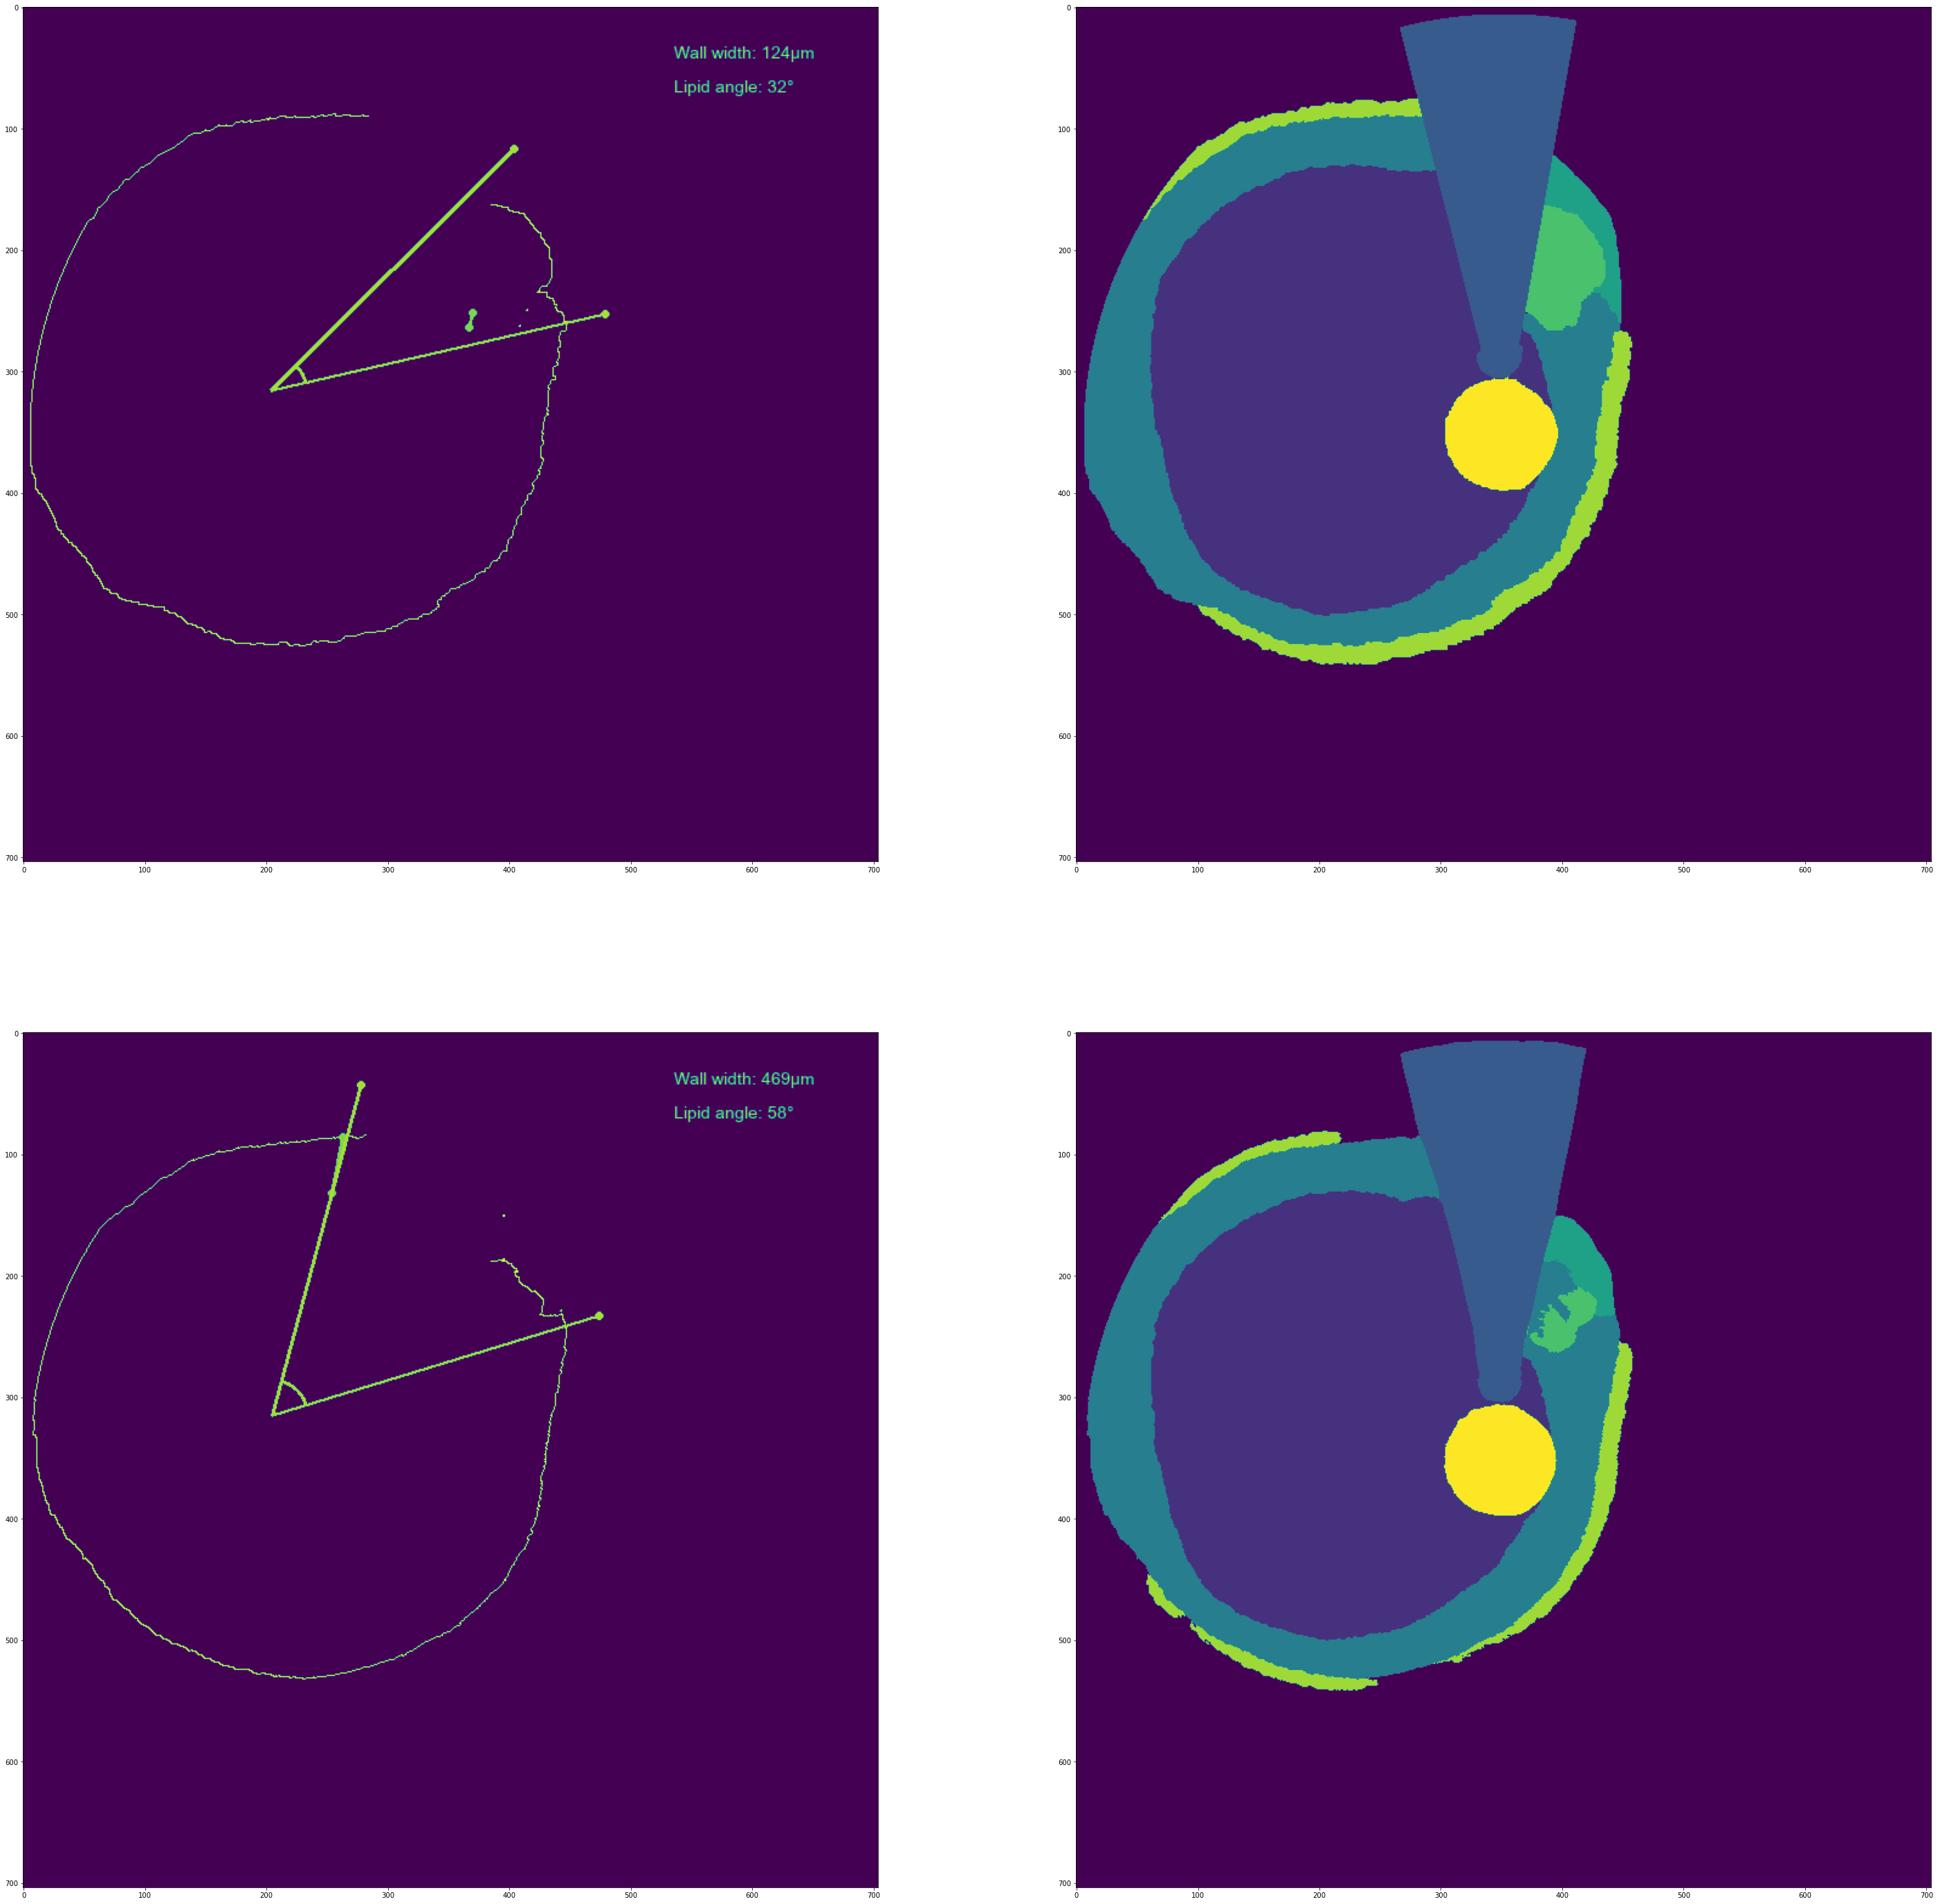

In [6]:
fig, axes = plt.subplots(2,2, figsize=(50,50))

axes = axes.flatten()

axes[0].imshow(image)
axes[1].imshow(orig_pixel_data)
axes[2].imshow(image2)
axes[3].imshow(img_pixel_data)

In [5]:
img = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\predicted_results_model3_2d\NLDISALA0097_1_frame320_052.nii.gz')

orig = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-2d\nnUNet_raw_data\Task503_CardiacOCT\labelsTs\NLDISALA0097_1_frame320_052.nii.gz')

image, thickness_bin, cap_thickness, lipid_arc = create_annotations(orig)
image2, thickness_bin2, cap_thickness2, lipid_arc2 = create_annotations(img)

C:\Users\gonza\AppData\Local\Temp\ipykernel_9796\2338012962.py:273: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pil_image = pil_image.resize((im_insize,im_insize), Image.NEAREST)


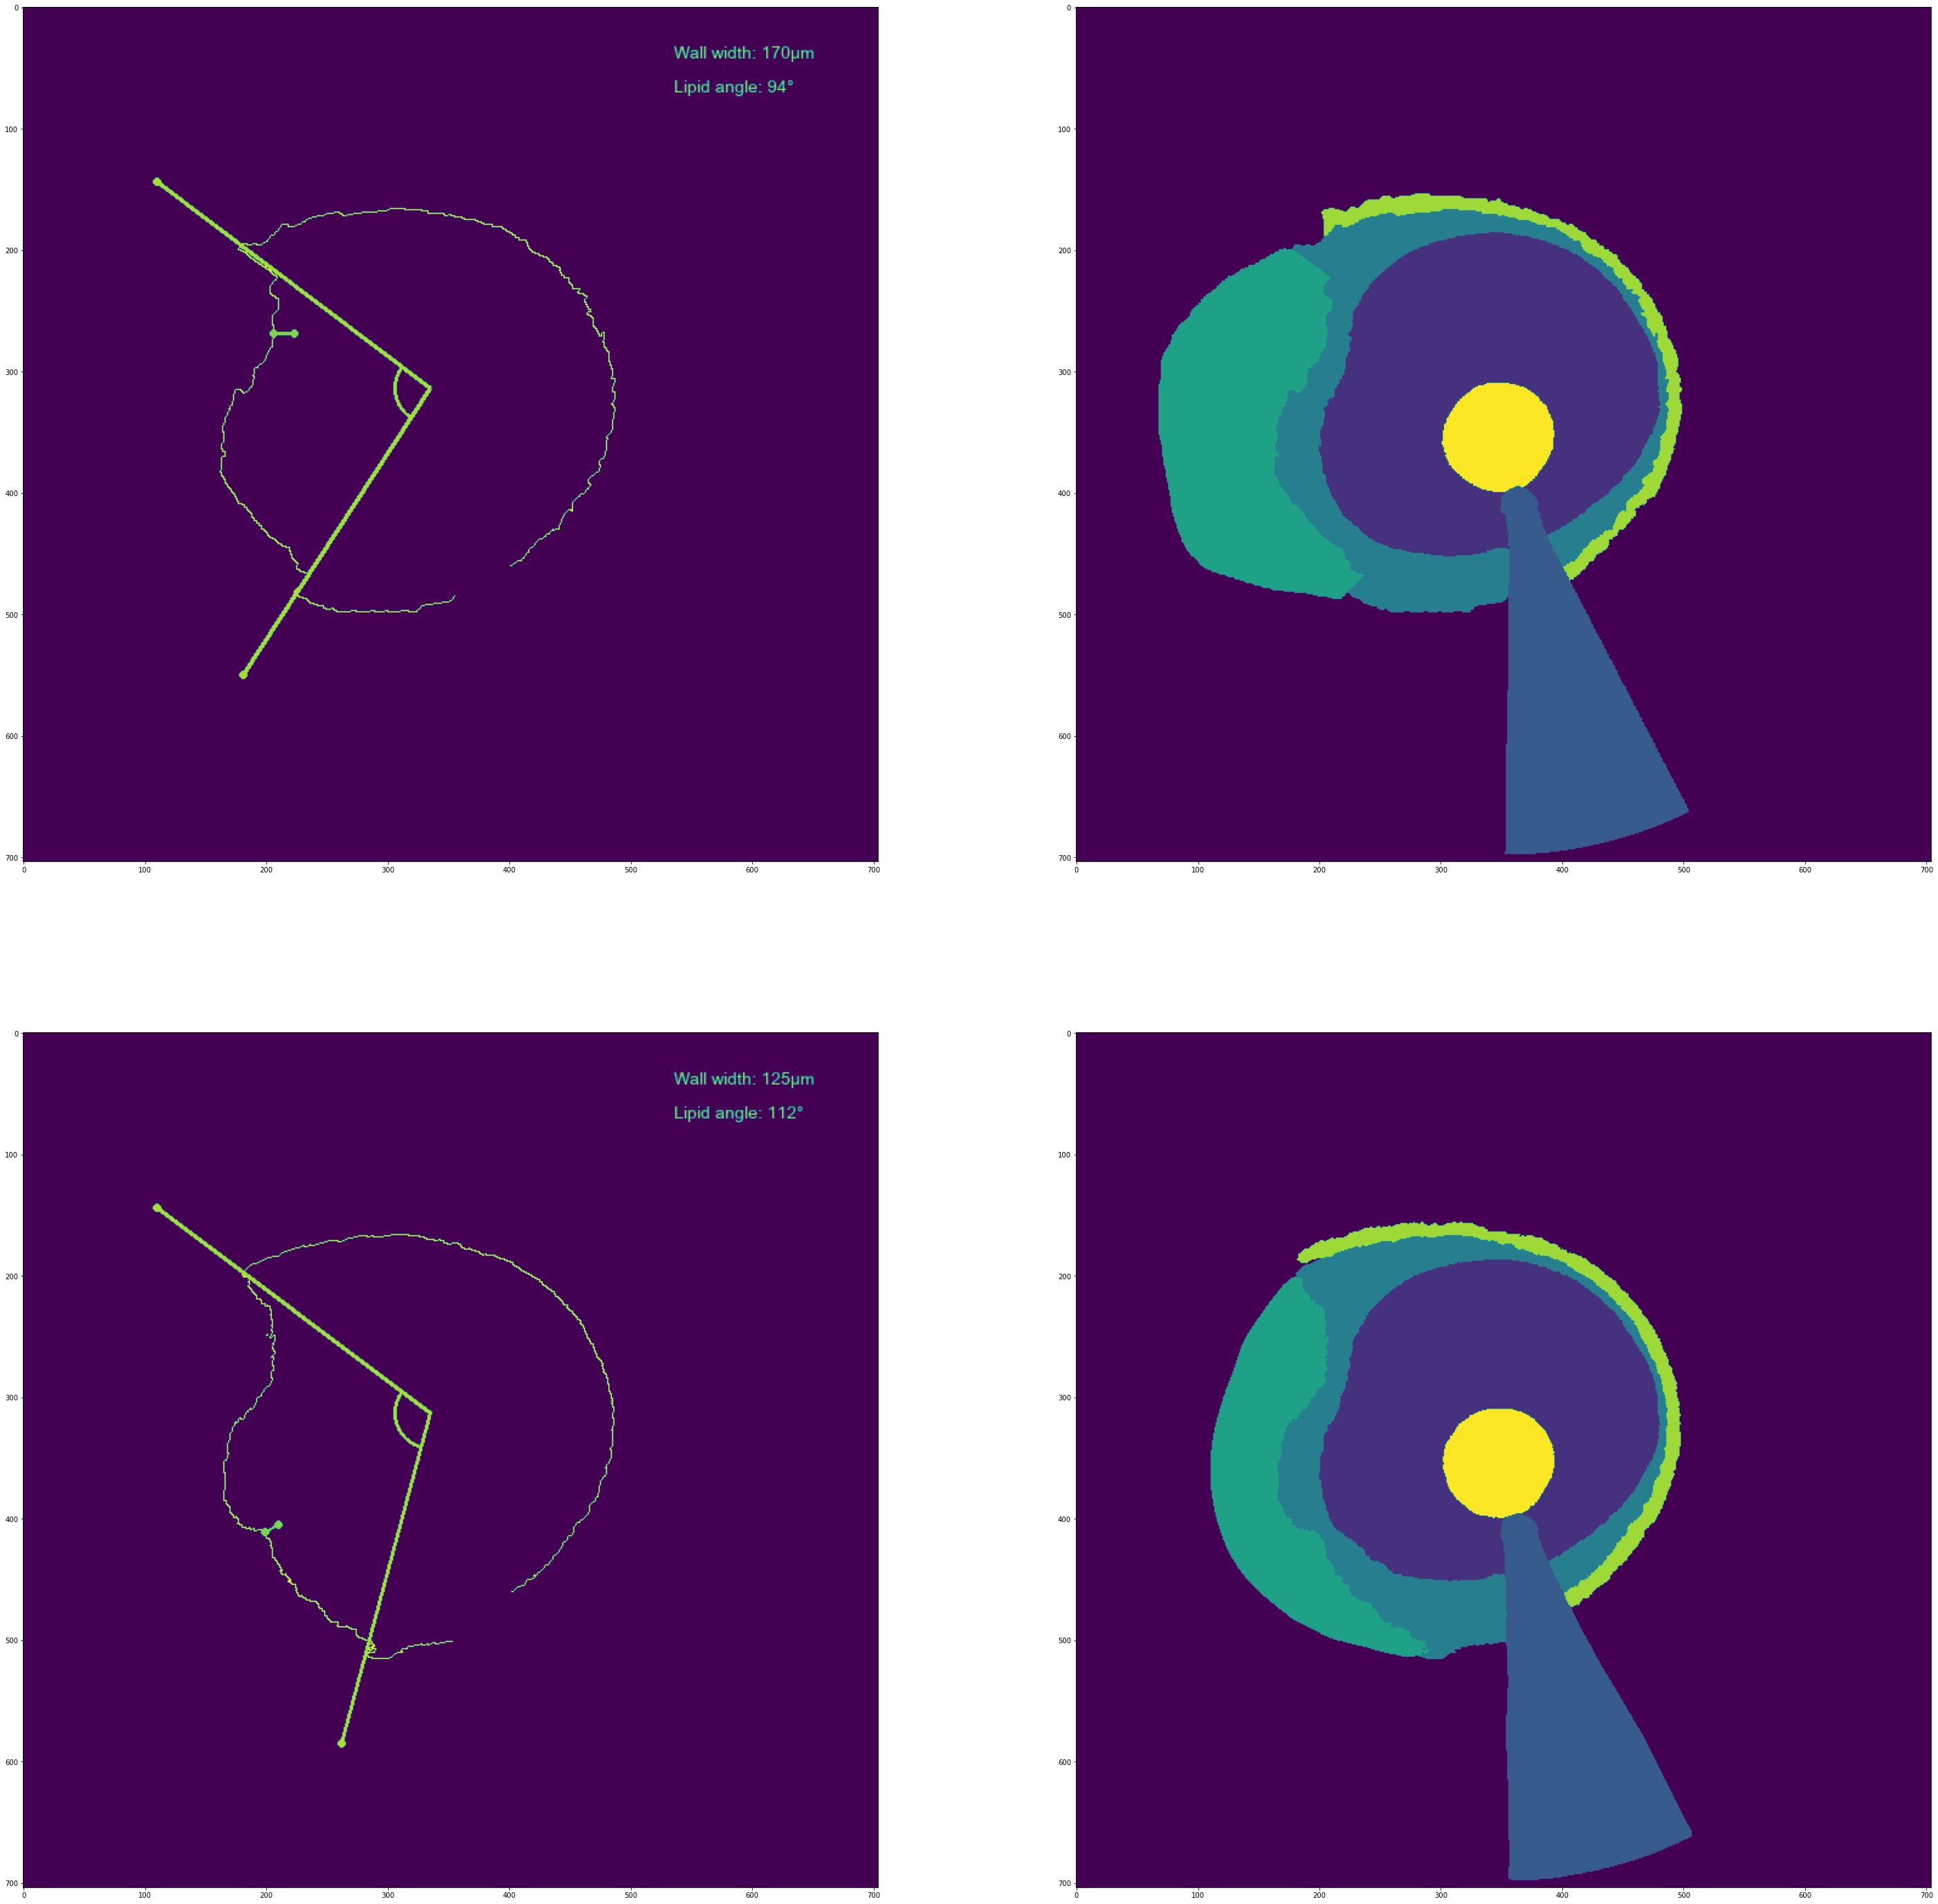

In [6]:
fig, axes = plt.subplots(2,2, figsize=(50,50))

axes = axes.flatten()

axes[0].imshow(image)
axes[1].imshow(orig_pixel_data)
axes[2].imshow(image2)
axes[3].imshow(img_pixel_data)

In [10]:
orig_dcm = sitk.ReadImage(r'Z:\grodriguez\CardiacOCT\data-original\scans-DICOM\NLD-ISALA-0097.dcm')
orig_dcm_data = sitk.GetArrayFromImage(orig_dcm)

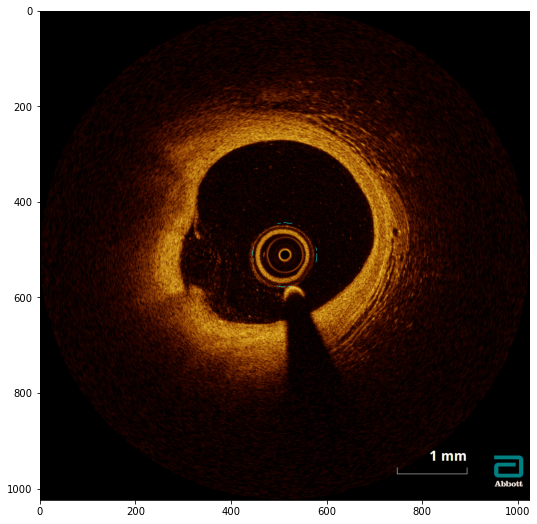

In [16]:
fig, axes = plt.subplots(1, figsize=(9,9))

axes.imshow(orig_dcm_data[320,:,:,:])